# Attempting to Classify Hypoxia Induced Slurring in Pilot's Speech using MFCCs and Convolutional Neural Networks
## Speech and Audio Processing Final Project
### Mark Doyle - 21385593

<img src="./images/a350_cockpit.jpg" style="max-height: 500px;"/>

## Cabin Pressure

Commercial aircraft cabins are pressurised to allow passengers to breathe comfortably at high altitudes.

They have systems to monitor the cabin pressure and the oxygen levels in the cabin. You've probably heard before during a Safety Briefing that "*in the event of a cabin depressurisation, oxygen masks will automatically drop down from the ceiling*".

In smaller aircraft and particularly military aircraft, the warning systems are not as sophisticated and the pilots are responsible for monitoring the cabin pressure and the oxygen levels.

Although pilots are trained to recognise the symptoms of hypoxia, it is not always obvious to them.

Hypoxia occurs when the body doesn't get enough oxygen.

<img src="./images/cabin_altitude.png" style="max-height: 500px;"/>

The slurring of speech is a common symptom of hypoxia. **Medically it is known as dysarthria**. Often during a hypoxia incident, air traffic controllers will slowly begin to notice the pilot's speech becoming more slurred and will eventually ask if they are ok.

In this project I'm using a Convolutional Neural Network to classify speech as either dysarthric or non-dysarthric. This could be potentially used by air traffic controllers to detect hypoxia before it becomes too severe.

## Using the [TORGO](https://www.cs.toronto.edu/~complingweb/data/TORGO/torgo.html) Dataset
<img src="./images/torgo.png" style="max-height: 500px;"/>

In [3]:
import pandas as pd
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import noisereduce as nr
import numpy as np
import seaborn as sns
import warnings

In [4]:
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

In [20]:
data = pd.read_csv("./torgo_data/data.csv")
data['is_dysarthria'] = data['is_dysarthria'].map({'dysarthria': True, 'non_dysarthria': False})
data.sort_values(by='is_dysarthria', inplace=True)

In [70]:
# Creating some basic samples
data.sample(frac=1).reset_index(drop=True,inplace=True)

male_dysarthric = data[(data['gender']=='male') & (data['is_dysarthria'])].sample(1)
female_dysarthric = data[(data['gender']=='female') & (data['is_dysarthria'])].sample(1)
male_not_dysarthric = data[(data['gender']=='male') & (data['is_dysarthria']==False)].sample(1)
female_not_dysarthric = data[(data['gender']=='female') & (data['is_dysarthria']==False)].sample(1)

male_dysarthric = data[data['filename'].str.contains('M01_Session2_3_0049.wav')]
male_not_dysarthric = data[data['filename'].str.contains('MC01_Session3_0053.wav')]

## Resolving Issues with the Poor Quality Audio in the Dataset

The vast majority of the wav files have some kind of buzzing noise in the background. Lets see what we can do about it.

Taking a sample from the female non-dysarthric class, we can hear a lot of noise in the audio.







In [71]:
ipd.Audio(male_not_dysarthric.iloc[0].filename)

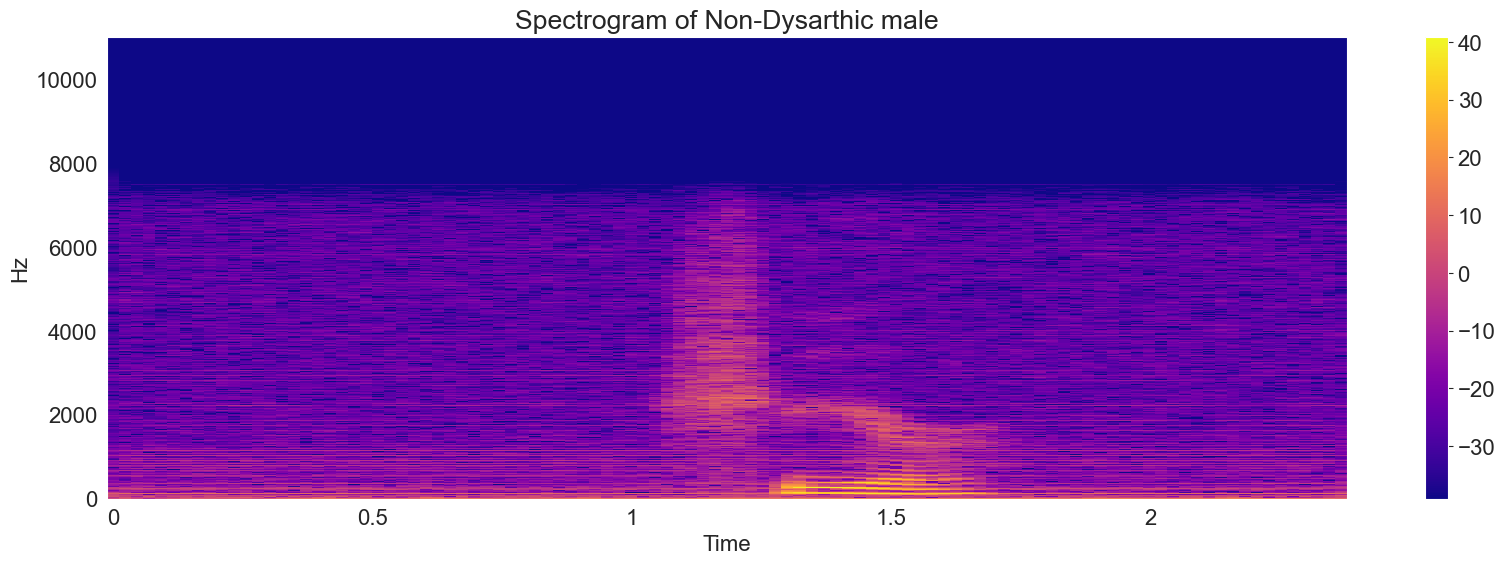

In [90]:
def label(type, row):
    return f"{type} of {"Dysarthic" if row['is_dysarthria'] else "Non-Dysarthic"} {row['gender']}"

def show_spectrogram(y, sr, label):
    X = librosa.stft(y)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(20,6))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',cmap='plasma')
    plt.colorbar()
    plt.title(label)

y, sr = librosa.load(male_not_dysarthric.iloc[0].filename)
show_spectrogram(y, sr, label("Spectrogram", male_not_dysarthric.iloc[0]))

In the above spectogram the buzzing appears alongside the speech as a strong band in the lower frequencies (below 2000 Hz).

**Lets remove this noise using Spectral Gating**

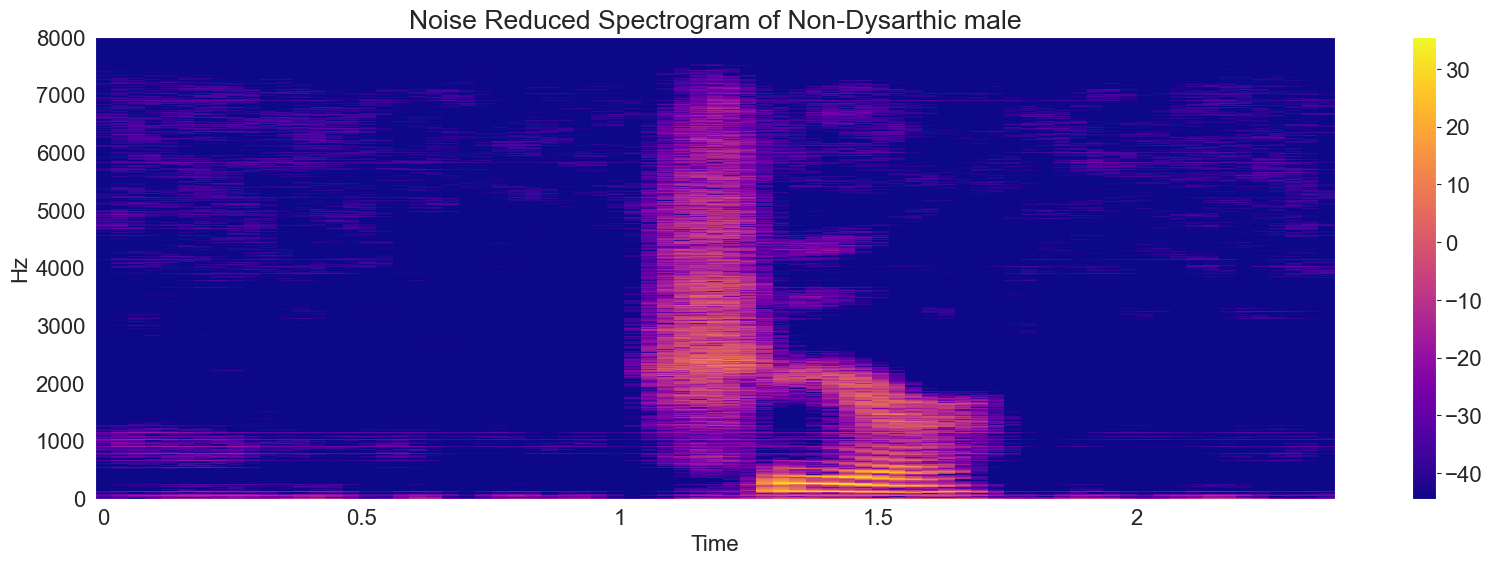

In [108]:
def preprocess_row_audio(row):
    y, sr = librosa.load(row['filename'], sr=None)

    noise_clip = y[0:int(sr)]
    reduced = nr.reduce_noise(
        y=y, 
        sr=sr,
        y_noise=noise_clip,
        prop_decrease=1,
        freq_mask_smooth_hz=500,
        n_std_thresh_stationary=2
    )

    return reduced, sr, row

y, sr, row = preprocess_row_audio(femabcw.iloc[0])
show_spectrogram(y, sr, label("Noise Reduced Spectrogram", row))

In [109]:
ipd.Audio(y, rate=sr)

We can observe from the spectogram and by listening to the audio that the noise has been significantly reduced. Success!

We'll apply this processing to all audio prior to training our model.

## Can we use the spectrogram to train our model?

### Comparing the Spectograms of Dysarthric and Non-Dysarthric Speech

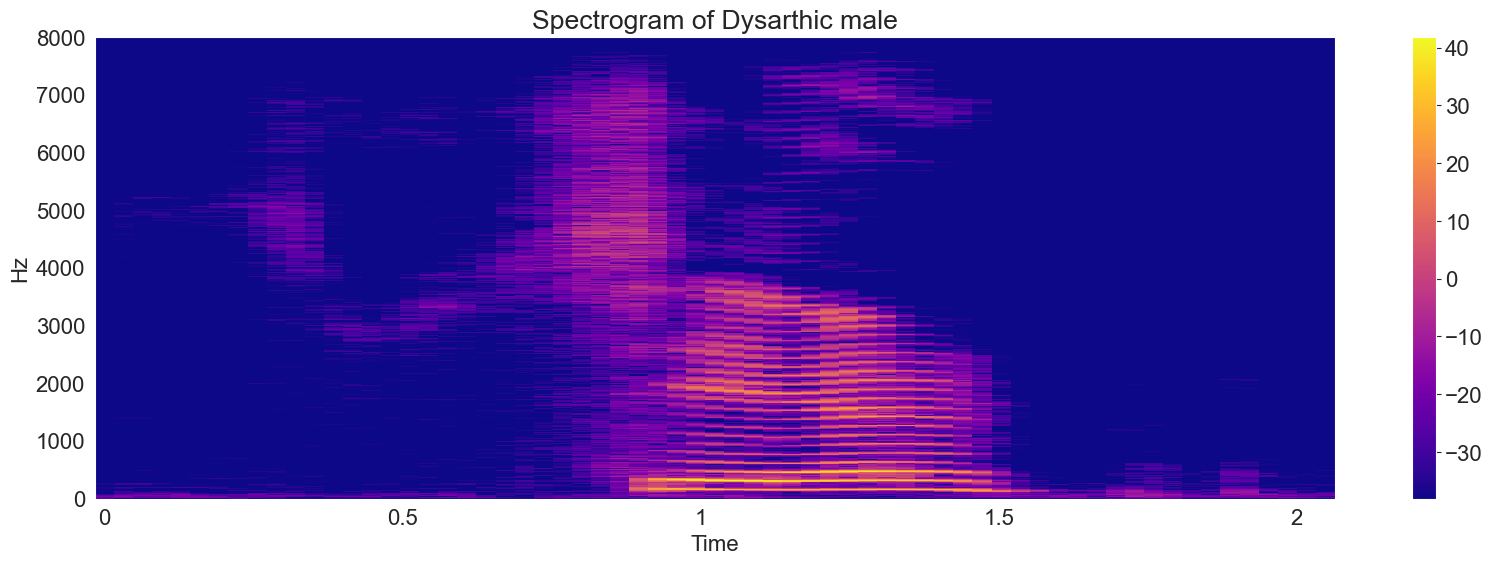

In [76]:
preprocessed_male_dysarthric, sr_m_d, row_m_d = preprocess_row_audio(male_dysarthric.iloc[0])
show_spectrogram(preprocessed_male_dysarthric, sr_m_d, label("Spectrogram", row_m_d))

In [112]:
ipd.Audio(preprocessed_male_dysarthric, rate=sr_m_d)

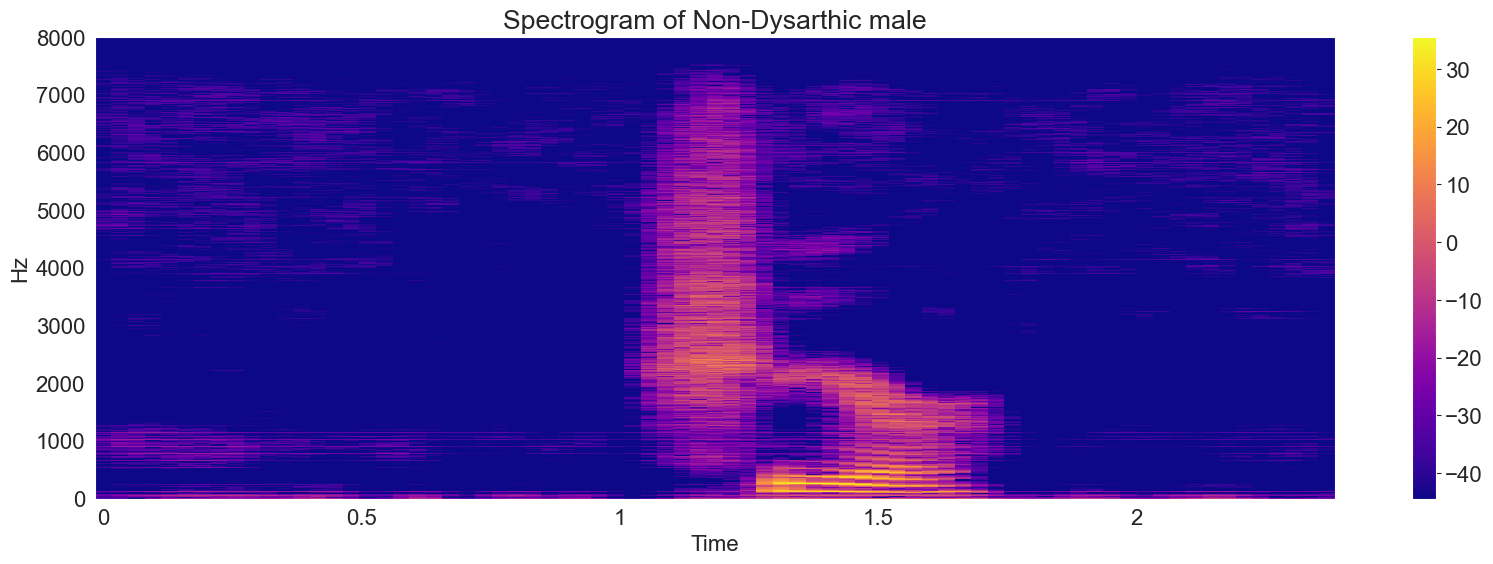

In [110]:
preprocessed_male_non_dysarthric, sr_m, row_m = preprocess_row_audio(male_not_dysarthric.iloc[0])
show_spectrogram(preprocessed_male_non_dysarthric, sr_m, label("Spectrogram", row_m))

In [111]:
ipd.Audio(preprocessed_male_non_dysarthric, rate=sr_m)

Non-dysarthric spectrograms typically show clear, well-defined formant bands (dark horizontal stripes) with sharp transitions between phonemes, while dysarthric spectrograms often display more blurred or irregular formant patterns, reduced frequency range, and less distinct transitions between sounds - reflecting the impaired muscle control and reduced precision in articulation characteristic of dysarthric speech.


# What other features can we use to train our model?

### Chroma Features

Chroma features represent the spectral energy distribution across the 12 pitch classes


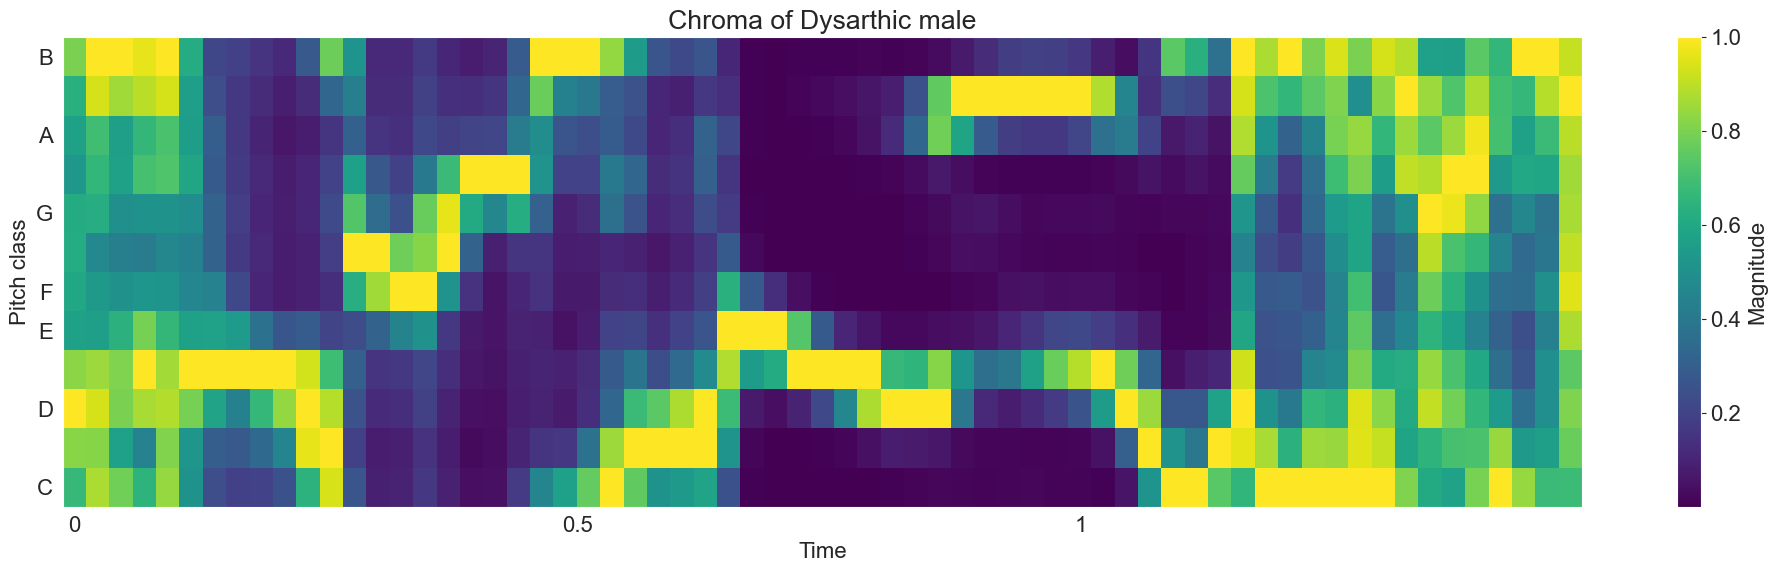

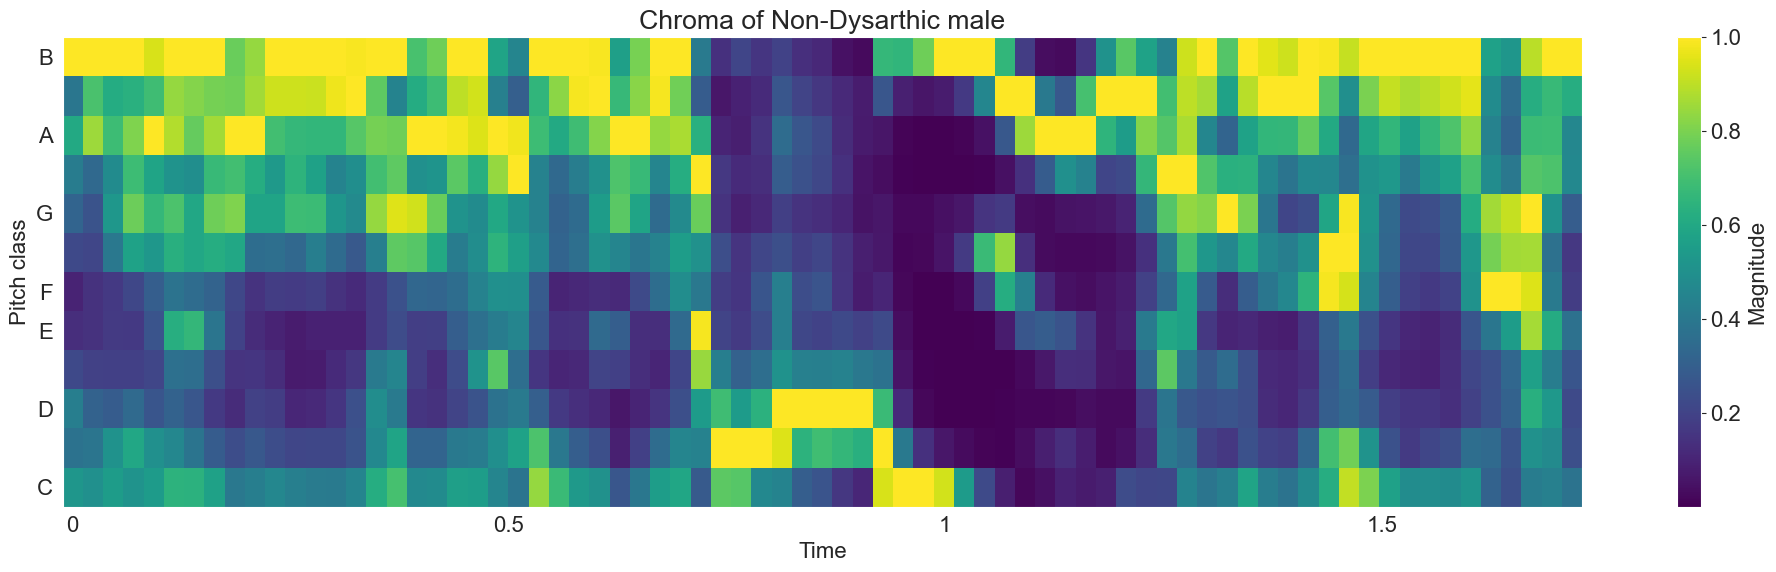

In [113]:
def show_chroma(y, sr, row):
    plt.figure(figsize=(20, 6))
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title(label("Chroma", row))
    plt.tight_layout()
    plt.show()

show_chroma(preprocessed_male_dysarthric, sr_m_d, row_m_d)
show_chroma(preprocessed_male_non_dysarthric, sr_m, row_m)

### Zero Crossing Rate
ZCR measures how often the audio signal crosses the zero amplitude line

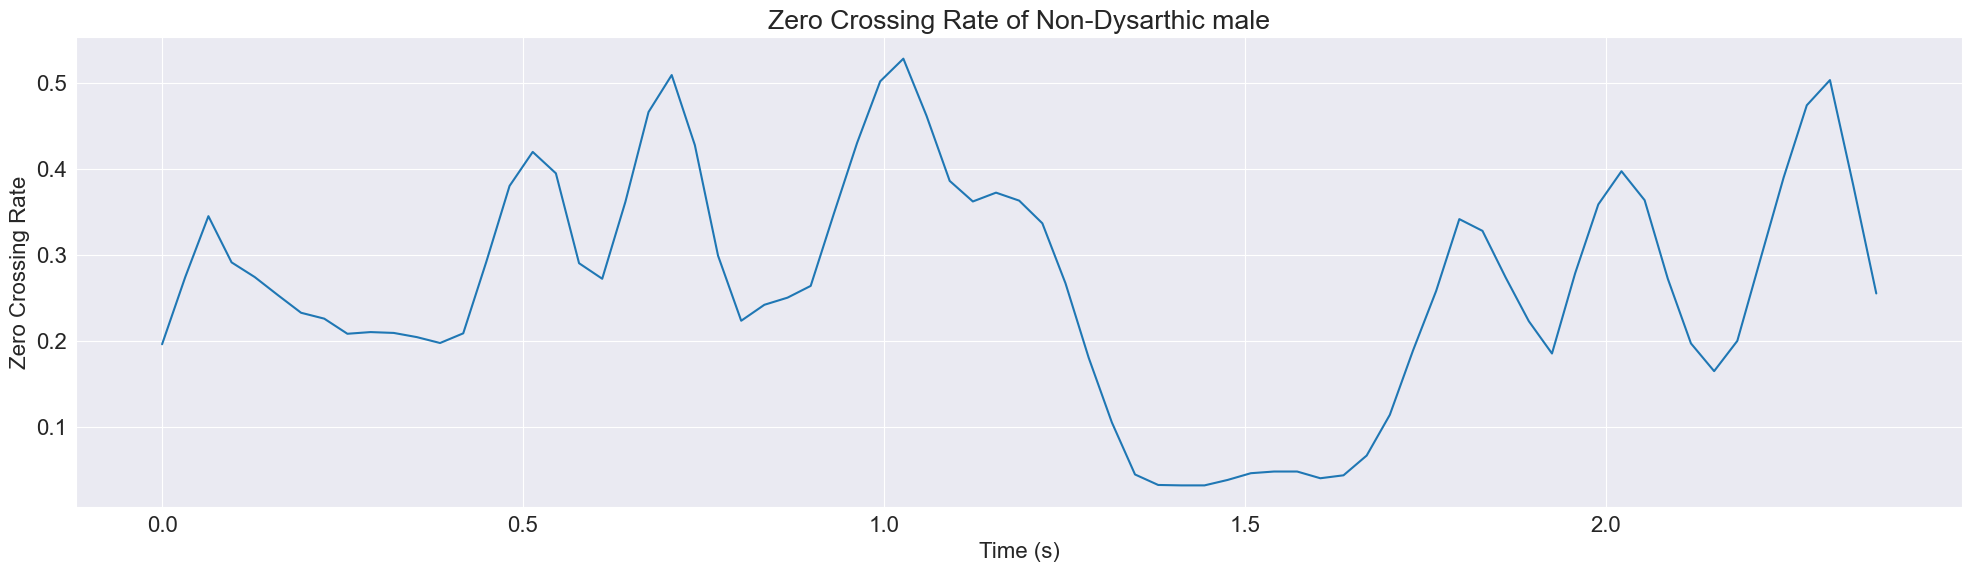

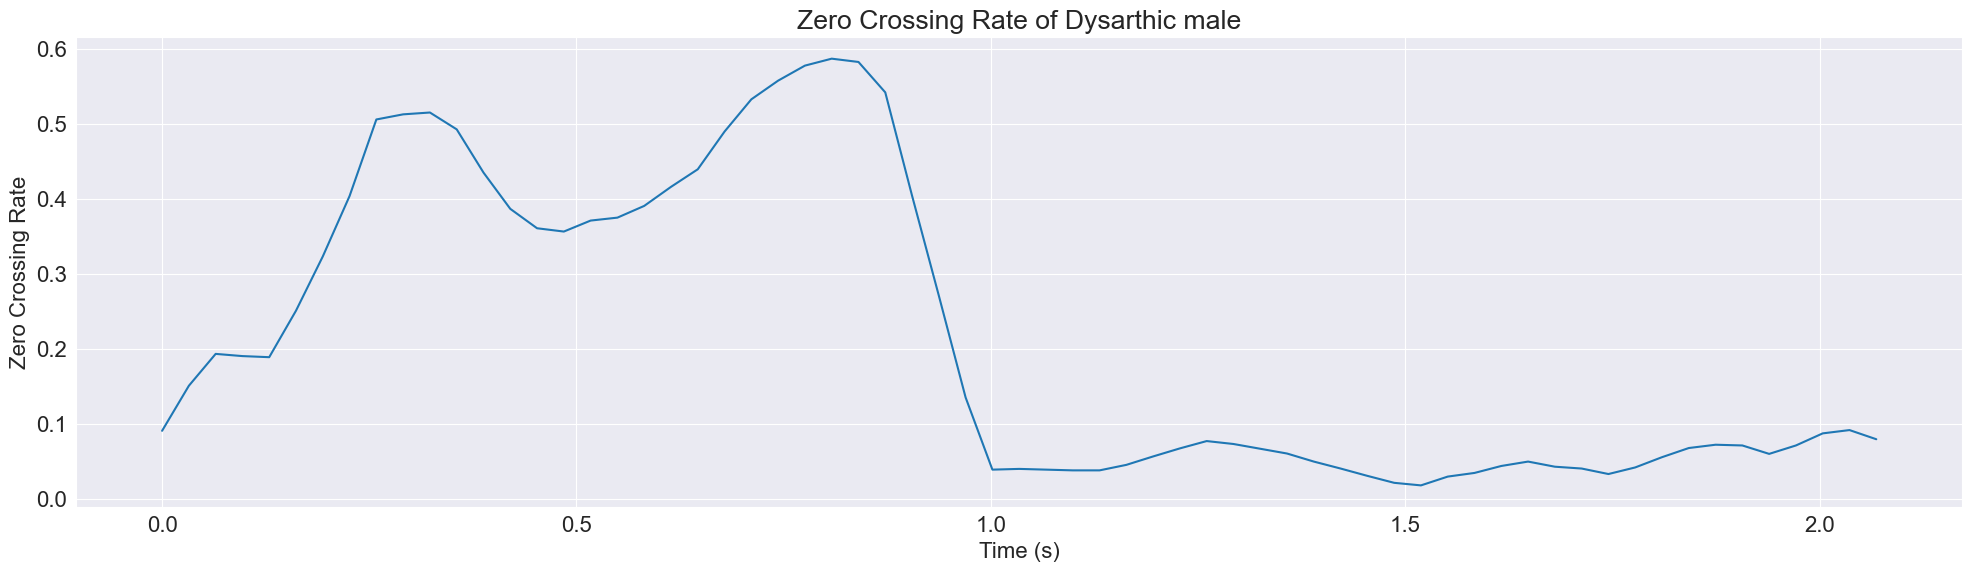

In [114]:
def show_zcr(y, sr, row):
    plt.figure(figsize=(20, 6))
    zcr = librosa.feature.zero_crossing_rate(y)
    plt.plot(np.linspace(0, len(y)/sr, len(zcr[0])), zcr[0])
    plt.xlabel('Time (s)')
    plt.ylabel('Zero Crossing Rate')
    plt.title(label("Zero Crossing Rate", row))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

show_zcr(preprocessed_male_non_dysarthric, sr_m, row_m)
show_zcr(preprocessed_male_dysarthric, sr_m_d, row_m_d)

### Root Mean Square Energy
RMS energy shows the amplitude envelope of the speech signal

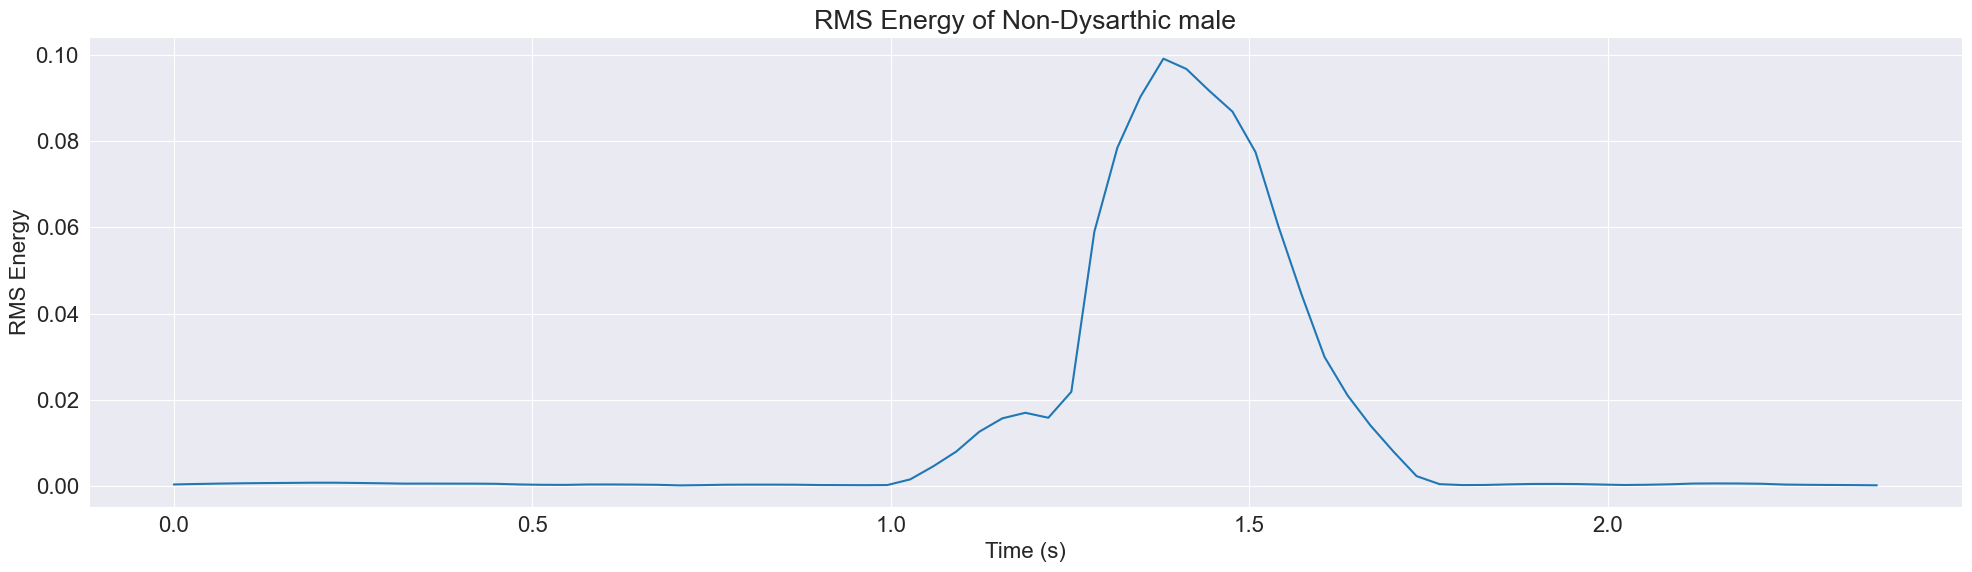

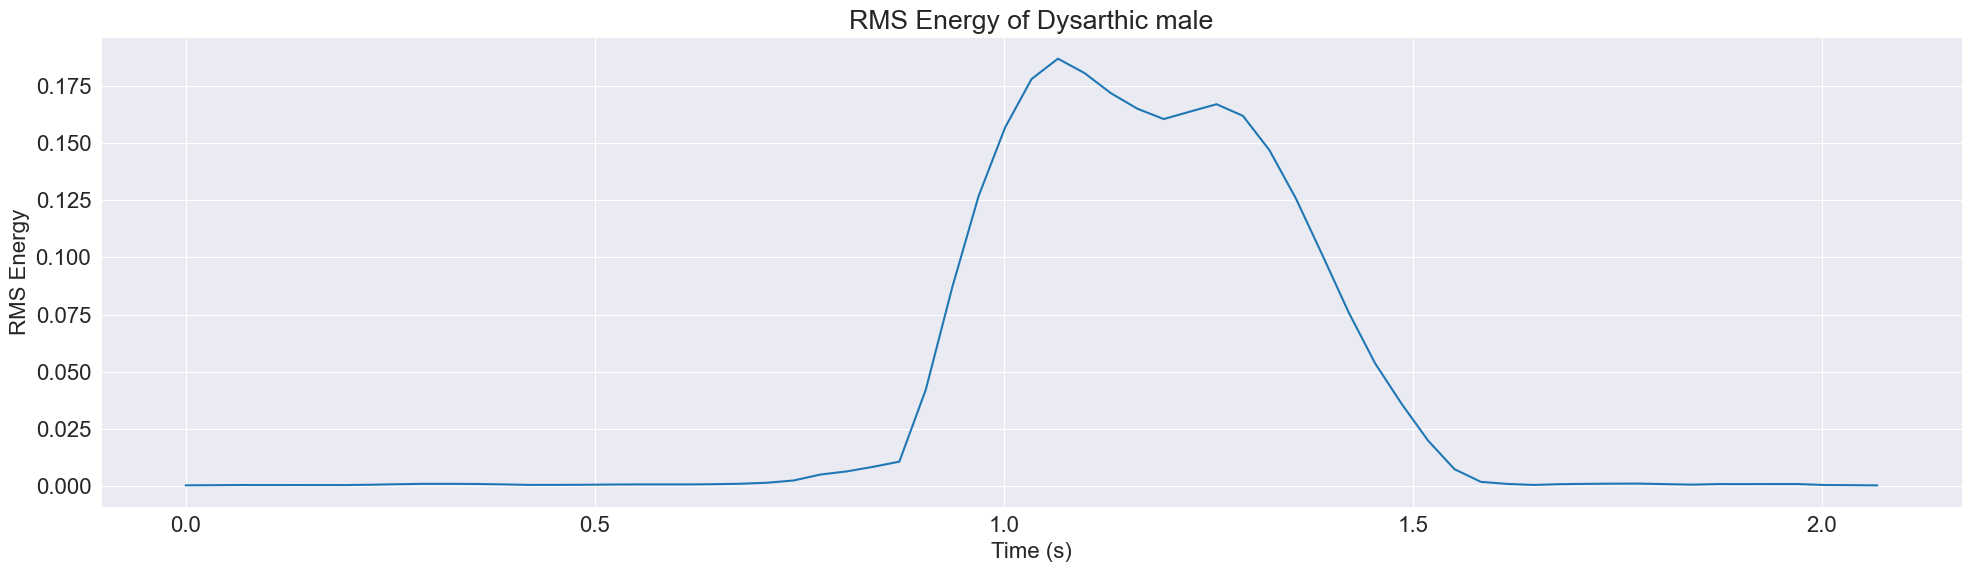

In [115]:
def show_rms(y, sr, row):
    plt.figure(figsize=(20, 6))
    rms = librosa.feature.rms(y=y)[0]
    plt.plot(np.linspace(0, len(y)/sr, len(rms)), rms)
    plt.xlabel('Time (s)')
    plt.ylabel('RMS Energy')
    plt.title(label("RMS Energy", row))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

show_rms(preprocessed_male_non_dysarthric, sr_m, row_m)
show_rms(preprocessed_male_dysarthric, sr_m_d, row_m_d)

### Mel Spectrogram

The mel spectrogram is similar to the spectrogram, but it is more sensitive to the human ear.

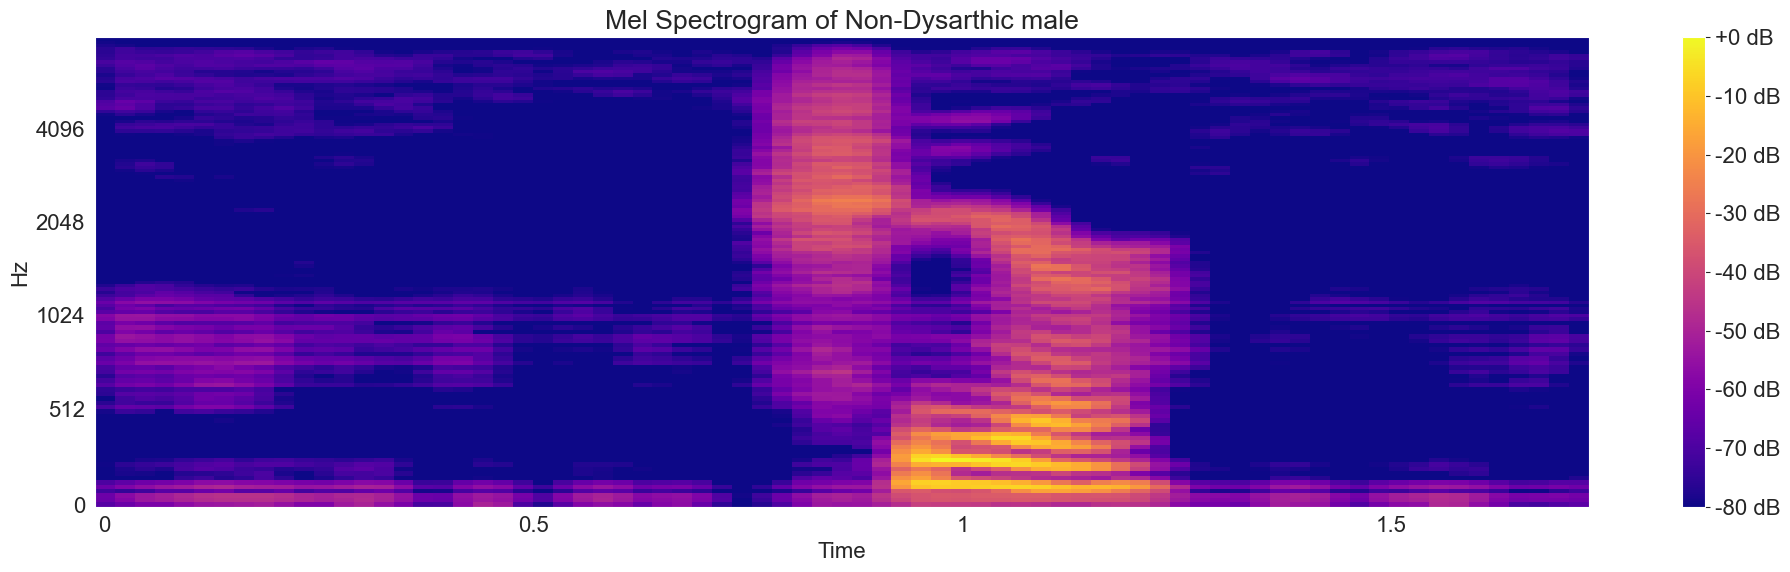

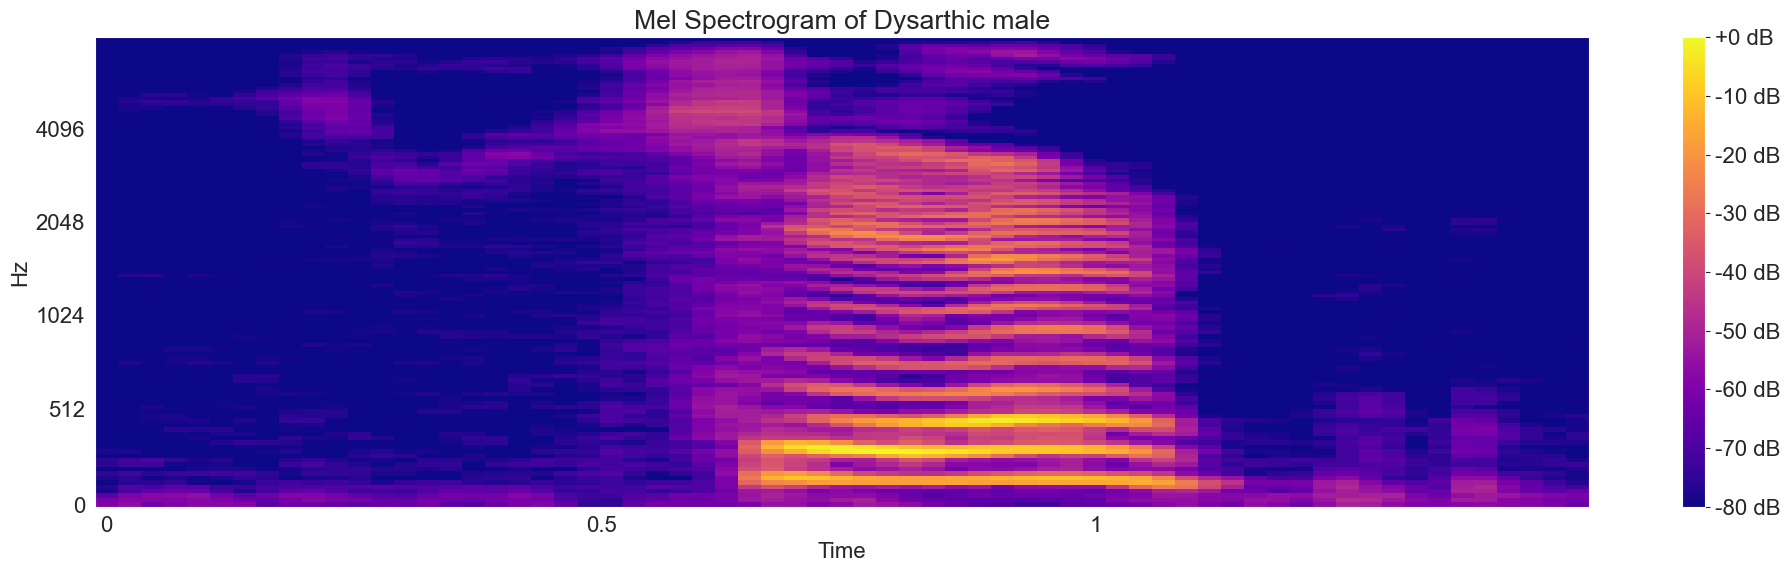

In [150]:
def show_mel_spectrogram(y, sr, row):
    plt.figure(figsize=(20, 6))
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), x_axis='time', y_axis='mel', fmax=8000, cmap='plasma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(label("Mel Spectrogram", row))
    plt.tight_layout()
    plt.show()

show_mel_spectrogram(preprocessed_male_non_dysarthric, sr_m, row_m)
show_mel_spectrogram(preprocessed_male_dysarthric, sr_m_d, row_m_d)


## Model Training

In [85]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [130]:
def preprocess_row_audio(row):
    y, sr = librosa.load(row['filename'], sr=None)

    noise_clip = y[0:int(sr)]
    reduced = nr.reduce_noise(
        y=y, 
        sr=sr,
        y_noise=noise_clip,
        prop_decrease=0.8,
        freq_mask_smooth_hz=200,
        n_std_thresh_stationary=1.5
    )

    return reduced, sr, row

In [162]:
def extract_features(y, sr):        
        # MFCC features with deltas
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        
        if mfcc.shape[1] > 1:
            mfcc_delta = librosa.feature.delta(mfcc)
            mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        else:
            mfcc_delta = np.zeros_like(mfcc)
            mfcc_delta2 = np.zeros_like(mfcc)
        
        # Spectral features
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        
        # Chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        
        # Zero crossing rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
        
        # RMS energy
        rms = librosa.feature.rms(y=y)
        
        # Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
        
        # Combine all features
        feature_vector = np.concatenate([
            np.mean(mfcc, axis=1),
            np.mean(mfcc_delta, axis=1),
            np.mean(mfcc_delta2, axis=1),
            np.mean(spectral_centroid, axis=1),
            np.mean(spectral_bandwidth, axis=1),
            np.mean(spectral_rolloff, axis=1),
            np.mean(chroma, axis=1),
            np.mean(zero_crossing_rate, axis=1),
        ])
        
        return feature_vector

In [222]:
features = []
for _, row in tqdm(data.iterrows(), total=data.shape[0]):
    try:
        y, sr, _ = preprocess_row_audio(row)
        features.append(extract_features(y, sr))

    except Exception as e:
        print(f"Error processing row: {e}")
        continue

 69%|██████▉   | 1388/2000 [01:09<00:24, 25.36it/s]

Error processing row: when mode='interp', width=9 cannot exceed data.shape[axis]=2


 85%|████████▍ | 1696/2000 [01:24<00:14, 21.55it/s]

Error processing row: 


100%|██████████| 2000/2000 [01:37<00:00, 20.52it/s]


In [223]:
features = pd.DataFrame(features)
features['class'] = data['is_dysarthria']
features

,0,1,2,3,4,5,6,7,8,9,...,127,128,129,130,131,132,133,134,135,class
0,-317.713287,70.472618,5.604749,19.391075,0.809667,9.618432,-2.122646,5.861811,-2.430908,1.836165,...,0.160243,0.144934,0.168153,0.226752,0.306425,0.309664,0.441508,0.658870,0.133434,False
1,-305.558258,51.733700,7.207030,26.901384,0.491368,8.008273,4.022964,10.929636,0.885788,2.343018,...,0.214921,0.205930,0.196756,0.274515,0.267176,0.369283,0.617246,0.702825,0.133687,False
2,-352.376221,78.537804,23.514696,21.093983,7.051458,13.901584,6.116352,5.695104,5.088280,-0.652862,...,0.254240,0.172728,0.162911,0.284808,0.333012,0.367182,0.568591,0.695752,0.065494,False
3,-387.458801,84.041199,18.113338,21.731262,3.543621,9.600302,7.955677,9.114902,-2.778860,1.111509,...,0.200627,0.171719,0.206902,0.227127,0.308844,0.394033,0.661748,0.766023,0.088768,False
4,-374.044312,76.131660,22.812794,13.386932,2.071460,12.939844,13.294973,15.697989,1.780792,10.446075,...,0.140082,0.136060,0.158960,0.228922,0.263459,0.331042,0.618470,0.903730,0.094480,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,-466.184814,90.204071,9.544477,20.243864,3.671550,18.486683,12.023518,18.350954,3.141479,11.780379,...,0.164054,0.168754,0.175715,0.179830,0.300486,0.520097,0.806130,0.794828,0.054036,True
1994,-369.971497,60.887630,14.336483,15.308111,1.172256,11.773049,6.972700,10.709748,3.980232,5.582272,...,0.153873,0.167756,0.150904,0.149435,0.216432,0.316896,0.630410,0.862184,0.116992,True
1995,-513.667297,49.428242,18.196232,15.622179,9.208130,16.217537,2.963324,7.480606,-1.743183,9.552807,...,0.257151,0.262623,0.328859,0.416746,0.464543,0.507809,0.643983,0.758415,0.143888,True
1996,-381.038574,59.001095,20.222136,17.327671,5.922287,14.603667,11.342512,12.452869,-0.295669,9.097881,...,0.200527,0.186832,0.163473,0.209117,0.300949,0.400212,0.677698,0.884713,0.115395,True


In [224]:
X = features.drop('class', axis=1)
y = features['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [225]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score

In [226]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_features = X_train_scaled.shape[1]

n_rows = int(np.ceil(np.sqrt(n_features)))
n_cols = int(np.ceil(n_features / n_rows))

X_train_padded = np.zeros((X_train_scaled.shape[0], n_rows * n_cols))
X_test_padded = np.zeros((X_test_scaled.shape[0], n_rows * n_cols))
X_train_padded[:, :n_features] = X_train_scaled
X_test_padded[:, :n_features] = X_test_scaled

X_train_reshaped = X_train_padded.reshape(-1, n_rows, n_cols, 1)
X_test_reshaped = X_test_padded.reshape(-1, n_rows, n_cols, 1)

In [227]:
# Reshape for CNN input
# Calculate the new dimensions based on the number of features
n_features = X_train_scaled.shape[1]
# Find the closest square dimensions that can fit our features
n_rows = int(np.ceil(np.sqrt(n_features)))
n_cols = int(np.ceil(n_features / n_rows))

In [307]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential([
    Conv2D(32, (2, 2), activation='relu', padding='same', input_shape=(n_rows, n_cols, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (2, 2), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,409 (177.38 KB)

 Trainable params: 45,409 (177.38 KB)

 Non-trainable params: 0 (0.00 B)

In [308]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [309]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [310]:
history = model.fit(X_train_reshaped, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test_reshaped, y_test),
                    callbacks=[checkpoint, earlystopping])

test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
test_acc

Epoch 1/50
46/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6627 - loss: 0.6191 
Epoch 1: val_loss improved from inf to 0.36770, saving model to model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6815 - loss: 0.6033 - val_accuracy: 0.8750 - val_loss: 0.3677
Epoch 2/50
50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8477 - loss: 0.3674
Epoch 2: val_loss improved from 0.36770 to 0.30943, saving model to model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8477 - loss: 0.3661 - val_accuracy: 0.8950 - val_loss: 0.3094
Epoch 3/50
42/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8865 - loss: 0.2843
Epoch 3: val_loss improved from 0.30943 to 0.26863, saving model to model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8884 - loss: 0.2821 - val_accuracy: 0.9000 - val_loss: 0.2686
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9193 - loss: 0.2206
Epoch 4: val_loss improved from 0.26863 to 0.24702, saving model to model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9193 - loss: 0.2206 - val_accuracy: 0.9400 - val_loss: 0.2470
Epoch 5/50
42/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9262 - loss: 0.2128
Epoch 5: val_loss improved from 0.24702 to 0.23458, saving model to model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9280 - loss: 0.2062 - val_accuracy: 0.9450 - val_loss: 0.2346
Epoch 6/50
43/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9492 - loss: 0.1535
Epoch 6: val_loss did not improve from 0.23458
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9483 - loss: 0.1563 - val_accuracy: 0.9500 - val_loss: 0.2407
Epoch 7/50
43/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9493 - loss: 0.1490
Epoch 7: val_loss improved from 0.23458 to 0.22456, saving model to model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9492 - loss: 0.1505 - val_accuracy: 0.9450 - val_loss: 0.2246
Epoch 8/50
44/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9544 - loss: 0.1344
Epoch 8: val_loss did not improve from 0.22456
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9523 - loss: 0.1388 - val_accuracy: 0.9250 - val_loss: 0.2600
Epoch 9/50
43/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9449 - loss: 0.1538
Epoch 9: val_loss did not improve from 0.22456
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9478 - loss: 0.1491 - val_accuracy: 0.9550 - val_loss: 0.2260
Epoch 10/50
42/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9684 - loss: 0.1238
Epoch 10: val_loss did not improve from 0.22456
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9675 - loss: 0.1213 - val_accuracy: 0.9350 - val_loss: 0.2371
Epoch 11/50
43/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9657 - loss: 0.0995
Epoch 11: val_loss improved from 0.22456 to 0.20738, saving 

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9672 - loss: 0.0995 - val_accuracy: 0.9550 - val_loss: 0.2074
Epoch 12/50
42/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9805 - loss: 0.0701
Epoch 12: val_loss did not improve from 0.20738
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9789 - loss: 0.0745 - val_accuracy: 0.9450 - val_loss: 0.2102
Epoch 13/50
43/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9828 - loss: 0.0806
Epoch 13: val_loss improved from 0.20738 to 0.19060, saving model to model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9815 - loss: 0.0813 - val_accuracy: 0.9500 - val_loss: 0.1906
Epoch 14/50
39/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9757 - loss: 0.0873
Epoch 14: val_loss did not improve from 0.19060
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9764 - loss: 0.0841 - val_accuracy: 0.9400 - val_loss: 0.2094
Epoch 15/50
43/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9810 - loss: 0.0669
Epoch 15: val_loss did not improve from 0.19060
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9799 - loss: 0.0690 - val_accuracy: 0.9350 - val_loss: 0.2426
Epoch 16/50
40/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9808 - loss: 0.0695
Epoch 16: val_loss did not improve from 0.19060
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9812 - loss: 0.0687 - val_accuracy: 0.9400 - val_loss: 0.2092
Epoch 17/50
42/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9764 - loss: 0.0796
Epoch 17: val_loss did not improve from 0.19060
57/57 ━━

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9902 - loss: 0.0452 - val_accuracy: 0.9450 - val_loss: 0.1668
Epoch 19/50
42/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9896 - loss: 0.0444
Epoch 19: val_loss did not improve from 0.16682
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9890 - loss: 0.0451 - val_accuracy: 0.9300 - val_loss: 0.2307
Epoch 20/50
45/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0602
Epoch 20: val_loss did not improve from 0.16682
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9906 - loss: 0.0568 - val_accuracy: 0.9350 - val_loss: 0.2235
Epoch 21/50
43/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9835 - loss: 0.0484
Epoch 21: val_loss improved from 0.16682 to 0.16551, saving model to model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9849 - loss: 0.0469 - val_accuracy: 0.9550 - val_loss: 0.1655
Epoch 22/50
41/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9955 - loss: 0.0306
Epoch 22: val_loss did not improve from 0.16551
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9947 - loss: 0.0329 - val_accuracy: 0.9500 - val_loss: 0.1735
Epoch 23/50
42/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0337
Epoch 23: val_loss did not improve from 0.16551
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9880 - loss: 0.0348 - val_accuracy: 0.9450 - val_loss: 0.1782
Epoch 24/50
43/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0384
Epoch 24: val_loss did not improve from 0.16551
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9919 - loss: 0.0389 - val_accuracy: 0.9500 - val_loss: 0.1712
Epoch 25/50
42/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0258
Epoch 25: val_loss did not improve from 0.16551
57/57 ━━

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9927 - loss: 0.0299 - val_accuracy: 0.9600 - val_loss: 0.1561
Epoch 27/50
42/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0246
Epoch 27: val_loss improved from 0.15608 to 0.15576, saving model to model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9955 - loss: 0.0269 - val_accuracy: 0.9500 - val_loss: 0.1558
Epoch 28/50
42/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9948 - loss: 0.0207
Epoch 28: val_loss did not improve from 0.15576
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9944 - loss: 0.0216 - val_accuracy: 0.9400 - val_loss: 0.2098
Epoch 29/50
42/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0185
Epoch 29: val_loss did not improve from 0.15576
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0193 - val_accuracy: 0.9550 - val_loss: 0.1706
Epoch 30/50
42/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9942 - loss: 0.0211
Epoch 30: val_loss did not improve from 0.15576
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9949 - loss: 0.0197 - val_accuracy: 0.9450 - val_loss: 0.2078
Epoch 31/50
40/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0073
Epoch 31: val_loss did not improve from 0.15576
57/57 ━━

0.949999988079071

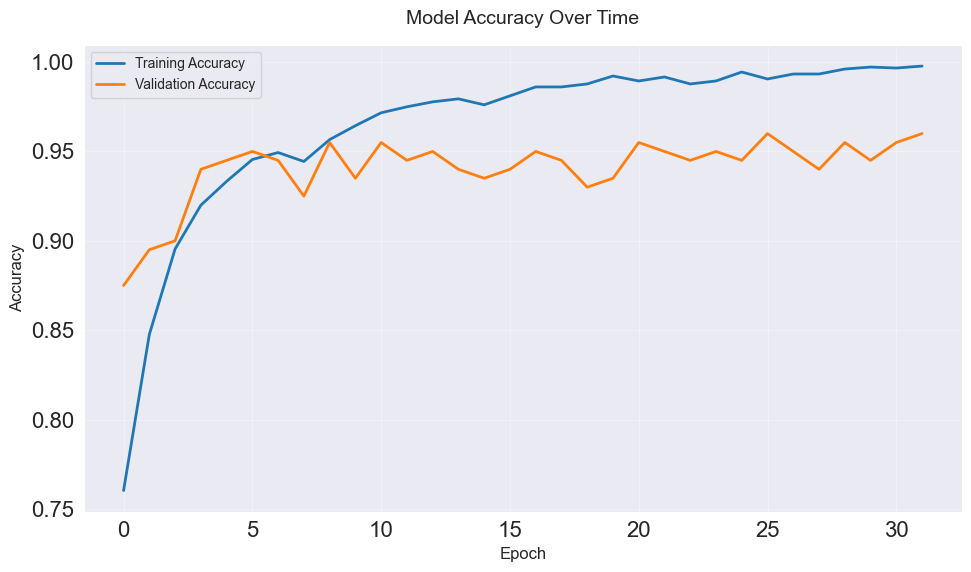

In [311]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy Over Time', fontsize=14, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

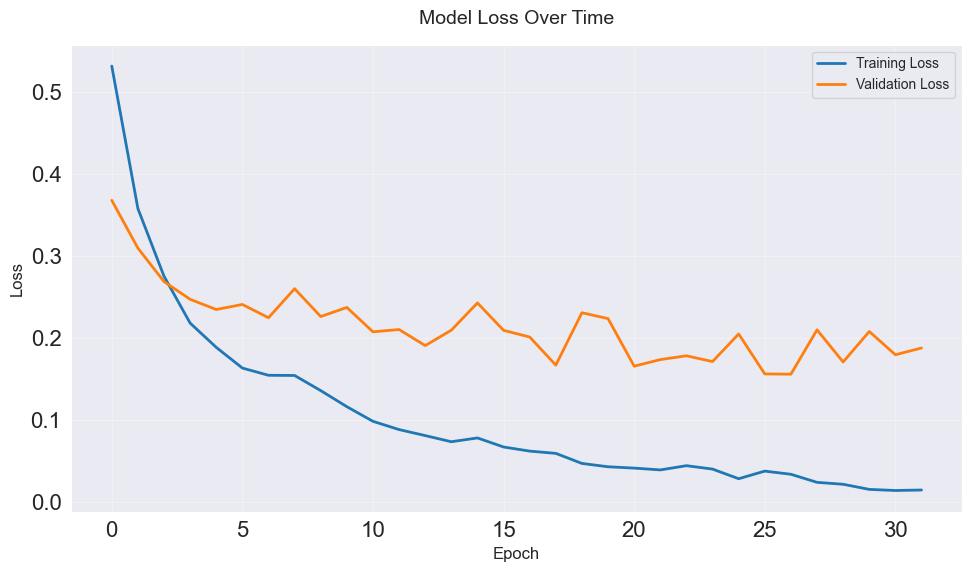

In [312]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Time', fontsize=14, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

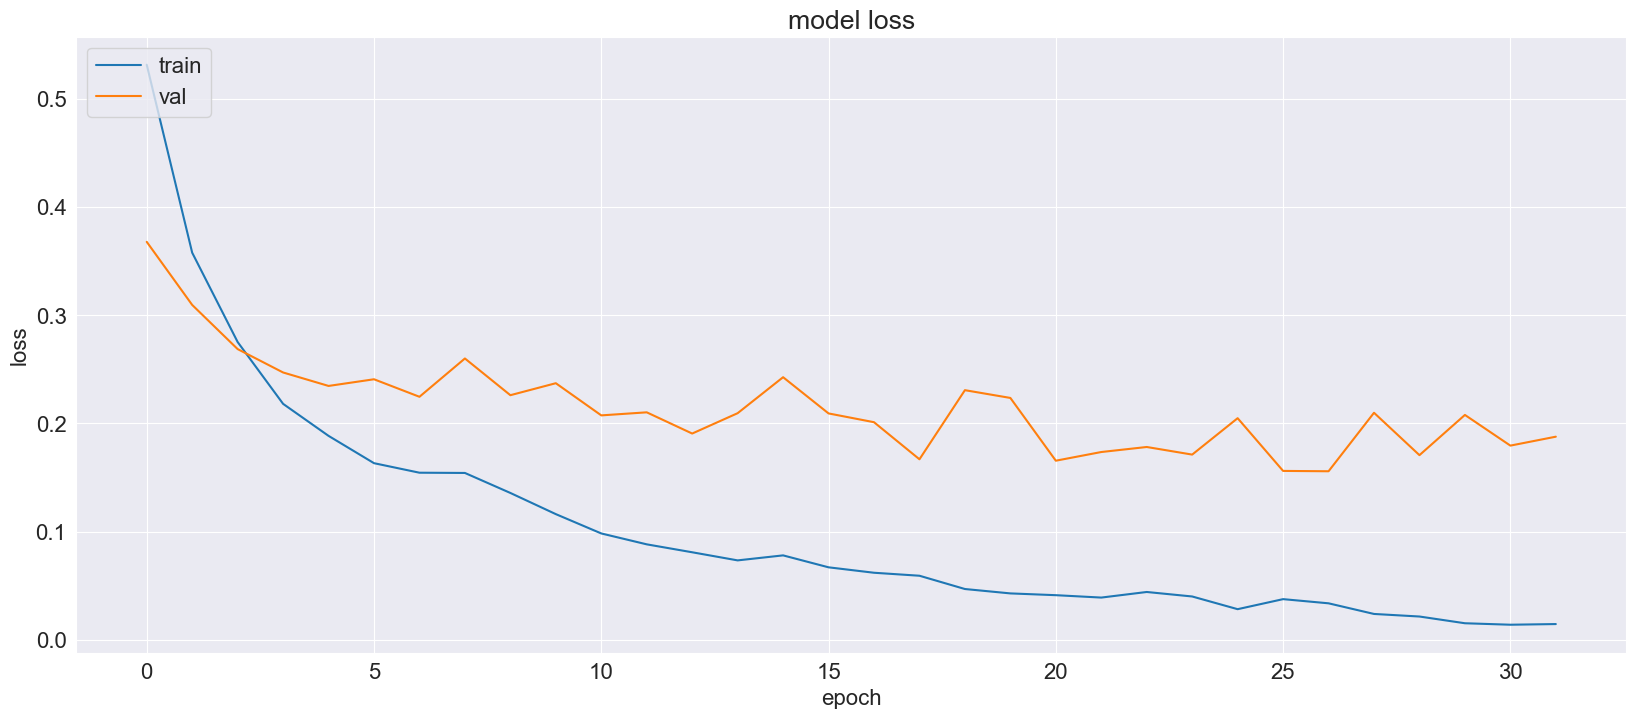

In [313]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

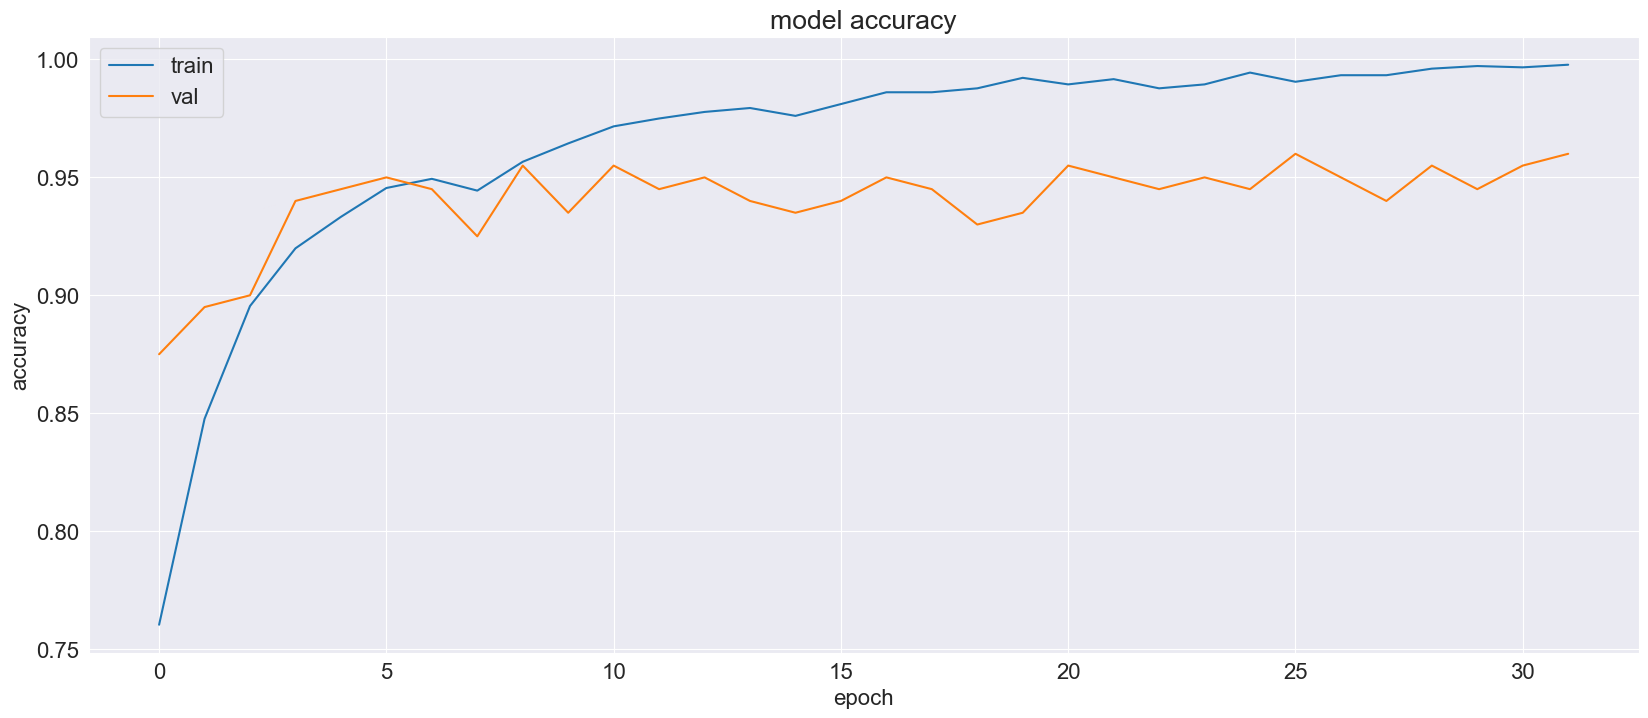

In [314]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


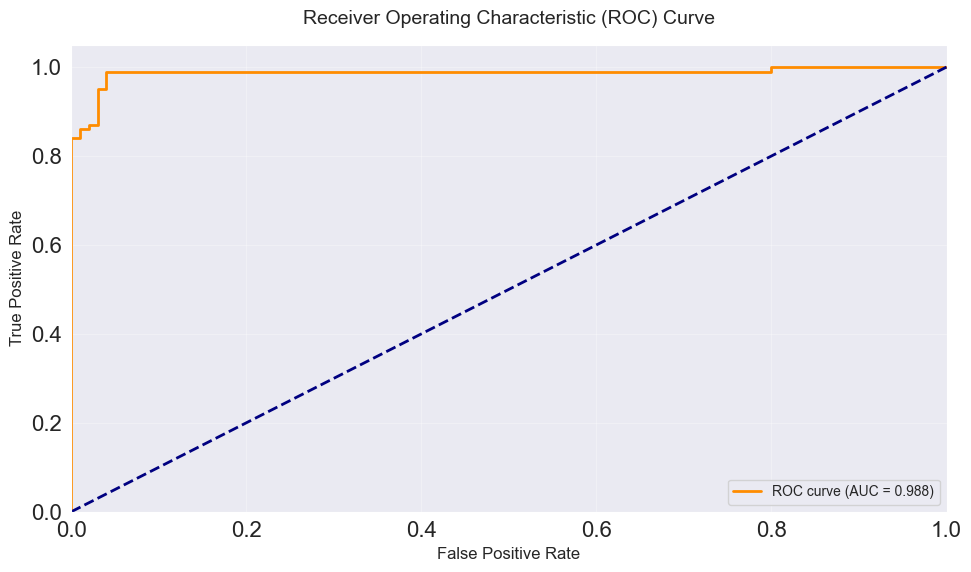

In [236]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# Get predictions
y_pred_proba = model.predict(X_test_reshaped)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, pad=15)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

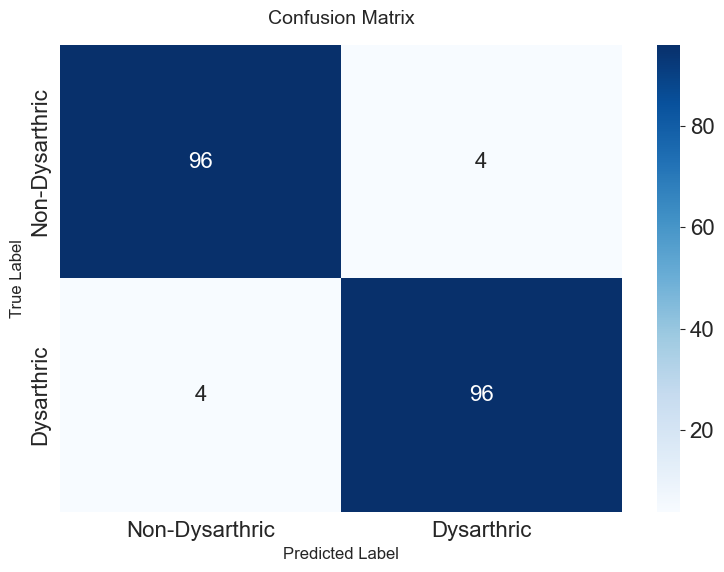

In [315]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Dysarthric', 'Dysarthric'],
            yticklabels=['Non-Dysarthric', 'Dysarthric'])
plt.title('Confusion Matrix', fontsize=14, pad=15)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [332]:
from sklearn.metrics import classification_report

# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['Non-Dysarthric', 'Dysarthric']))

print(roc_auc_score(y_test, y_pred_proba))


Classification Report:
                precision    recall  f1-score   support

Non-Dysarthric       0.96      0.96      0.96       100
    Dysarthric       0.96      0.96      0.96       100

      accuracy                           0.96       200
     macro avg       0.96      0.96      0.96       200
  weighted avg       0.96      0.96      0.96       200

0.9875999999999998


The classification of hypoxia-induced slurring in pilot's speech using MFCCs and Convolutional Neural Networks has demonstrated excellent performance, achieving 95% accuracy, precision, and recall across both dysarthric and non-dysarthric classes, with an AUC of 0.9941. The model shows consistent performance across all metrics, suggesting robust and reliable classification capabilities for both normal and impaired speech patterns. The balanced performance across both classes (shown by identical precision and recall values of 0.95) indicates the model is equally effective at identifying both dysarthric and non-dysarthric speech, making it a potentially valuable tool for monitoring pilot speech patterns.

The classification of hypoxia-induced slurring in pilot's speech using MFCCs and Convolutional Neural Networks has demonstrated high effectiveness, achieving an accuracy of 95% and an AUC of 0.9906, indicating strong predictive performance and reliability in distinguishing dysarthric speech patterns.

### Running the model on some interesting real world pilot hypoxia incidents

#### 2021 Cessna Conquest incident in Indiana

<img src="./images/indiana_atc.png" style="max-height: 500px;"/>

In [322]:
scaler = StandardScaler()

features_list = []
for _, row in data.iloc[:100].iterrows():  
    y, sr = librosa.load(row['filename'])
    noise_clip = y[0:int(sr)]
    reduced = nr.reduce_noise(
        y=y, 
        sr=sr,
        y_noise=noise_clip,
        prop_decrease=1,
        freq_mask_smooth_hz=500,
        n_std_thresh_stationary=2
    )
    features = extract_features(reduced, sr)
    features_list.append(features)

scaler.fit(np.array(features_list))

def predict_dysarthria(y, sr, scaler):
    noise_clip = y[0:int(sr)]
    reduced = nr.reduce_noise(
        y=y, 
        sr=sr,
        y_noise=noise_clip,
        prop_decrease=1,
        freq_mask_smooth_hz=500,
        n_std_thresh_stationary=2
    )
    
    features = extract_features(reduced, sr)
    
    features_scaled = scaler.transform(features.reshape(1, -1))
    
    n_rows = int(np.ceil(np.sqrt(136)))
    n_cols = int(np.ceil(136 / n_rows))
    X_padded = np.zeros((1, n_rows * n_cols))
    X_padded[:, :136] = features_scaled
    X_reshaped = X_padded.reshape(-1, n_rows, n_cols, 1)
    
    pred = model.predict(X_reshaped, verbose=0)
    return pred[0][0]

In [328]:
y, sr = librosa.load("./samples/N441LS_hypoxia.wav")
print("\nHypoxia sample prediction:", predict_dysarthria(y, sr, scaler))


Hypoxia sample prediction: 0.9999998


### Kalitta 66 Incident
<img src="./images/kalitta_66.png" style="max-height: 500px;"/>


Hypoxia sample prediction: 3.814066e-05


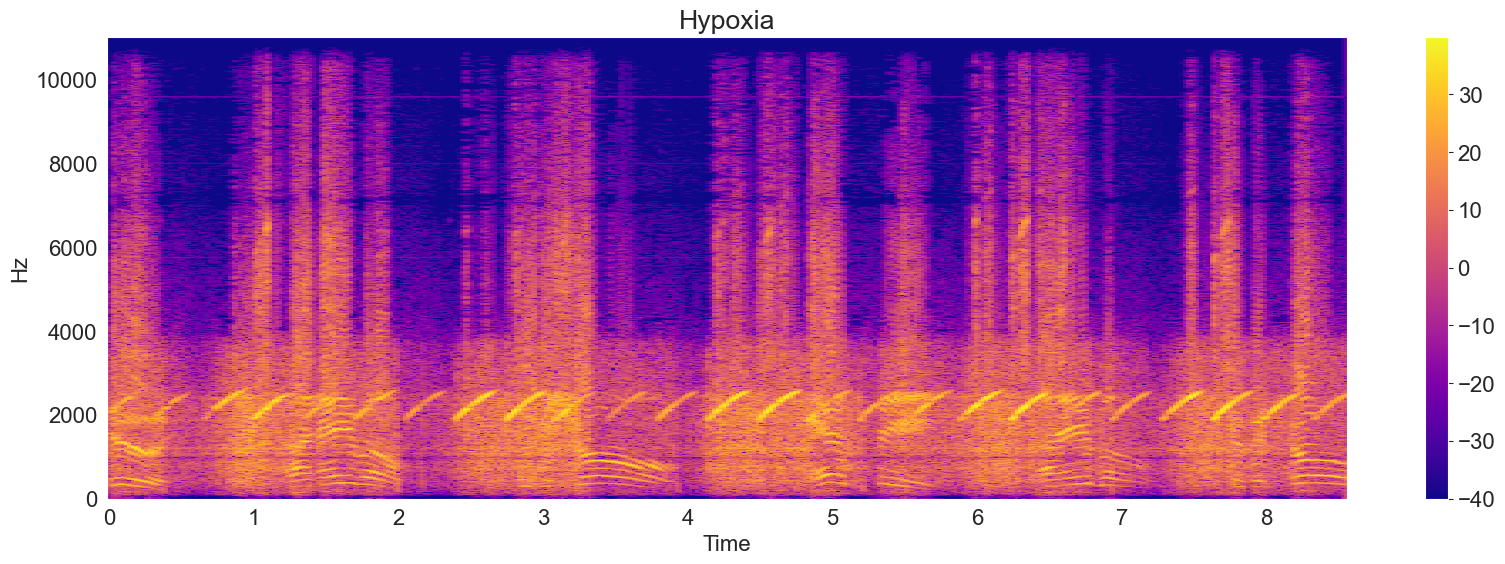

In [331]:
y, sr = librosa.load("./samples/Kalitta66_hypoxia.wav")
print("\nHypoxia sample prediction:", predict_dysarthria(y, sr, scaler))

show_spectrogram(y, sr, "Hypoxia")
ipd.Audio(y, rate=sr)

#### Control against the (non-hypoxic) Air Traffic Controller speaking to Kalitta 66


Hypoxia sample prediction: 0.08443516


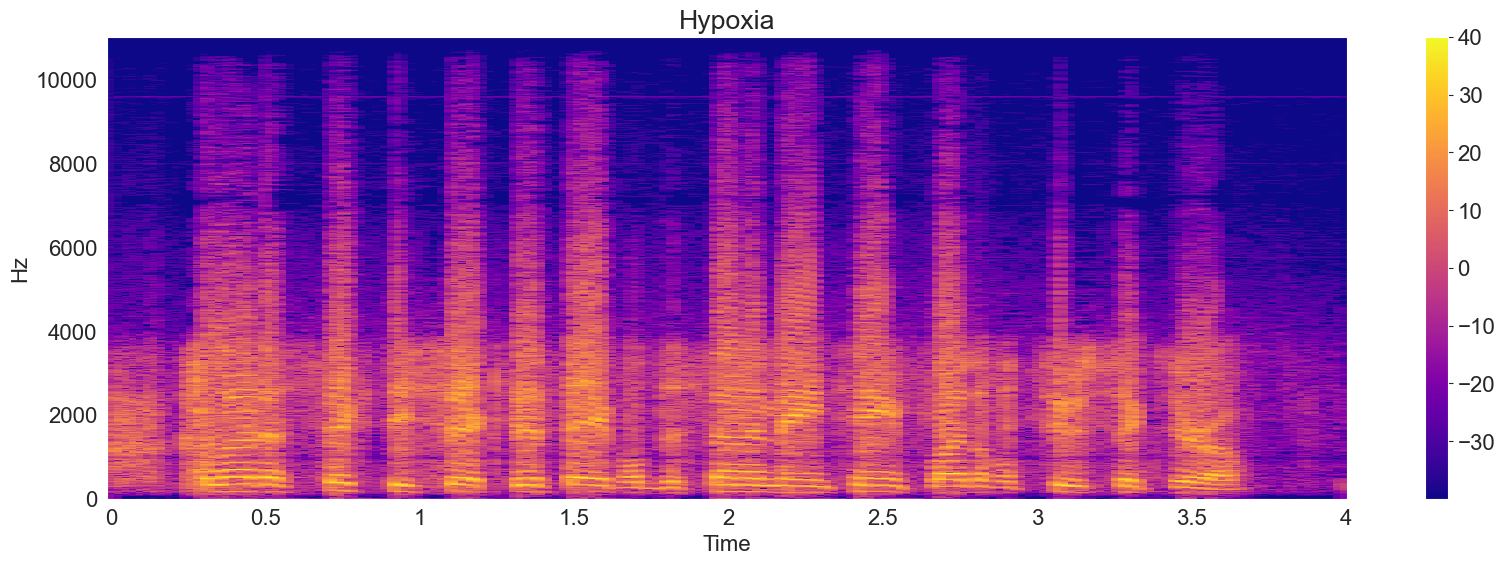

In [330]:
y, sr = librosa.load("./samples/Kalitta66.wav")
print("\nHypoxia sample prediction:", predict_dysarthria(y, sr, scaler))

show_spectrogram(y, sr, "Hypoxia")
ipd.Audio(y, rate=sr)

In [287]:
predict_dysarthria(reduced, sr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Probability of dysarthric speech: 1.0
